In [1]:
# importing the module 
%matplotlib inline
import json 
import ase
import numpy as np
from ase import Atoms, Atom
from amptorch.trainer import AtomsTrainer
import pickle
from ase.io.trajectory import Trajectory
from ase.io import read
import sys
import time
import torch
import os
import csv
import ase.io
import copy
from scipy.stats import gaussian_kde
import matplotlib
import matplotlib.pyplot as plt
import pickle

In [2]:
dict_path2configs = {
    1: <input dropout model no. 1 checkpoint dir>,
    2: <input dropout model no. 2 checkpoint dir>,
    3: <input dropout model no. 3 checkpoint dir>,
    4: <input dropout model no. 4 checkpoint dir>,
}

ensemble_index = range(1, 5)
trial = 50000
list_path2configs = [dict_path2configs[_] for _ in ensemble_index]

In [3]:
# plot setting
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
colors=["#f14432", "#fc8a6a"]

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Set figure defaults
width = 6.5 / 3
fontsize = 10
rc = {'figure.figsize': (width, width),
#       'font.family': "serif",
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': 'small',
      'ytick.labelsize': 'small',
      'legend.fontsize': fontsize}

matplotlib.rcParams.update(rc)

In [4]:
# cwd = os.getcwd()
# workspace_name = "latent_analyze_ensemble{}".format(len(list_path2configs))
# if not os.path.exists(workspace_name):
#     os.makedirs(workspace_name)
# os.chdir("./" + workspace_name)

In [5]:
def predict_data(pred_energies, test_images):
    
    true_energies = np.array([image.get_potential_energy() for image in test_images])

    list_of_error_per_atom = []

    for i, image in enumerate(test_images):
        num_atoms = len(image.get_atomic_numbers())
        total_energy_pred = pred_energies[i]
        total_energy_true = true_energies[i]

        error = pred_energies[i] - true_energies[i]
        per_atom_error = error / num_atoms
        list_of_error_per_atom.append(per_atom_error)

    return list_of_error_per_atom

In [6]:
test_filename = <input test dataset dir>
test_list = ase.io.read(test_filename, index=":")

In [9]:
# iteration starts
mat_residuals_test = np.empty((len(test_list), len(list_path2configs)))

for i in range(len(list_path2configs)):
    path2config = list_path2configs[i]
    trainer_load = AtomsTrainer()
    trainer_load.load_pretrained(path2config)
    pred_energies_test = trainer_load.predict(test_list)["energy"]
    residuals_test = np.array(predict_data(pred_energies_test, test_list))
    
    mat_residuals_test[:, i] = residuals_test
    

Loading checkpoint from ./checkpoints/2022-05-04-17-54-01-data50000-ordernorm_dropout_sigma10logwide_MCSH3_NN32_constrs1.0_sh1
Use Xavier initialization
Loading model: 11393 parameters
Loading skorch trainer
Loading checkpoint from ./checkpoints/2022-05-04-19-49-08-data50000-ordernorm_dropout_sigma10logwide_MCSH3_NN32_constrs1.0_sh1
Use Xavier initialization
Loading model: 11393 parameters
Loading skorch trainer
Loading checkpoint from ./checkpoints/2022-05-04-21-05-40-data50000-ordernorm_dropout_sigma10logwide_MCSH3_NN32_constrs1.0_sh1
Use Xavier initialization
Loading model: 11393 parameters
Loading skorch trainer
Loading checkpoint from ./checkpoints/2022-05-04-21-52-21-data50000-ordernorm_dropout_sigma10logwide_MCSH3_NN32_constrs1.0_sh1
Use Xavier initialization
Loading model: 11393 parameters
Loading skorch trainer


In [10]:
# convert energy from kcal/mol to meV/sys
mat_residuals_test *= 0.04336 * 1000

In [11]:
test_std = np.std(mat_residuals_test, axis=1)
test_avg = np.mean(mat_residuals_test, axis=1)

In [15]:
def get_p_one_two_outsideTwo(test_sub_epa, test_latent_std):
    # one std
    len_one_std = np.where(np.abs(test_avg) < np.abs(test_std))[0]
    len_one_std = len(len_one_std)
    p_one_std = len_one_std / len(test_sub_epa)
    
    # two stds
    len_two_std = np.where(np.abs(test_avg) < 2 * np.abs(test_std))[0]
    len_two_std = len(len_two_std)
    p_two_std = len_two_std / len(test_sub_epa)

    # outside two stds
    p_overconfidence = 1 - p_two_std
    
    return (p_one_std, p_two_std, p_overconfidence)

In [24]:
import matplotlib.patheffects as PathEffects

def plot_scatter_residuals_vs_dropout_std(std_test, residuals_test, xlabel="dropout s.d. [meV/sys]", title=None, save_filename=None,dpi=None):
    std_test = copy.deepcopy(std_test)
    residuals_test = copy.deepcopy(residuals_test)
    xy = np.vstack([std_test, residuals_test])
    z = gaussian_kde(xy)(xy)
    # plot one std
    ref_fx = np.linspace(np.amin(std_test), np.amax(std_test), 100)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    std_test, residuals_test, z = std_test[idx], residuals_test[idx], z[idx]

    ax.plot(ref_fx, ref_fx,c=colors[0])
    ax.plot(ref_fx, - ref_fx,c=colors[0])

    ax.plot(ref_fx, 2 * ref_fx,c=colors[1])
    ax.plot(ref_fx, - 2 * ref_fx,c=colors[1])

    ax.fill_between(ref_fx, ref_fx, -ref_fx, alpha=0.2, color=colors[0] , linewidth=0)
    ax.fill_between(ref_fx, 2 * ref_fx, - 2 * ref_fx, alpha=0.2, color=colors[1], linewidth=0)
    ax.plot(ref_fx, [0]*100, "--", color="darkgray")
    
    x_lower_lim = np.quantile(std_test, 1e-4)
    x_upper_lim = np.quantile(std_test, 0.998)
    
    # force share-y
    ax.set_xlim([0, x_upper_lim])
    ax.set_ylim([-7.5, 7.5])

    # add text of prob
    prob_posi = (x_upper_lim - x_lower_lim) * .8 + x_lower_lim
    p_1, p_2, p_3 = get_p_one_two_outsideTwo(residuals_test, std_test)
    txt = ax.text(prob_posi, 1, "{:.0f}%".format(p_1*100), color=colors[0])
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w')])
    txt = ax.text(prob_posi, 4.1, "{:.0f}%".format(p_2*100), color=colors[1])
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w')])
    txt = ax.text(prob_posi*0.7, 6., "{:.0f}%".format(p_3*100), color="k")
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w')])

    pcm = ax.scatter(std_test, residuals_test, c=z, s=20, linewidths=None, alpha=.2)

    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel("residual [meV/sys]")

    if title is not None:
        ax.set_title(title)
    return fig, ax

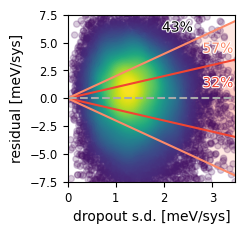

In [26]:
fig_filename = "./figures/panel_method_comparison/dropout_std_dpi300.png"
fig, ax = plt.subplots(figsize=(width, width))
fig, ax = plot_scatter_residuals_vs_dropout_std(test_std, test_avg)
fig.savefig(fig_filename, dpi=300, bbox_inches='tight',transparent=True)
fig
# plot_scatter_residuals_vs_ensemble_std(test_std, test_avg, save_filename="./figures/panel_method_comparison/ensemble_std_dpi300.png",dpi=300)

In [27]:
# analyze which the portion of test data in between one to two std

from scipy.stats import norm

# count the number of instances

expected_stds = np.linspace(norm.ppf(1e-4),
                norm.ppf(1-1e-4), 15)

# normalize 
test_avg_norm = test_avg / test_std

expected_ps = []
observed_ps = []

for std in expected_stds: 
    count = np.sum(test_avg_norm < std)
    observed_ps.append(count / len(test_avg_norm))
    expected_ps.append(norm.cdf(std))

# calculate the area of miscalculation in calibration curve

from scipy.integrate import trapz

area = 0

for i in range(1, len(observed_ps)+1):
    trap = np.abs(trapz(observed_ps[i-1:i+1], expected_ps[i-1:i+1]) 
                  - trapz(expected_ps[i-1:i+1], expected_ps[i-1:i+1]))
    area += trap

area

0.12582207809310583

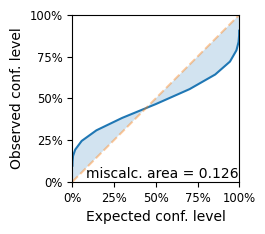

In [28]:
import matplotlib.ticker as mtick

expected_ps = np.array(expected_ps) * 100 # convert to %
observed_ps = np.array(observed_ps) * 100 # convert to %

fig, ax = plt.subplots(figsize=(width,width))
ax.plot(expected_ps, observed_ps)
ax.plot(expected_ps, expected_ps, "--", alpha=0.4)

ax.fill_between(expected_ps, expected_ps, observed_ps, alpha=0.2, linewidth=0)
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
ax.set_aspect('equal')

ax.set_xlabel("Expected conf. level")
ax.set_ylabel("Observed conf. level")
ax.locator_params(axis='y', nbins=4)
ax.locator_params(axis='x', nbins=4)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.text(8, 2, "miscalc. area = {:.3f}".format(area))


save_filename = "./figures/panel_method_comparison/dropout_std_calibration_curve.pdf"
# fig.savefig(save_filename,bbox_inches='tight',transparent=True)
fig

In [50]:
# average uncertainty in meV/sys
np.mean(test_std)

29.68069618761512